In [131]:
from tweepy import OAuthHandler, Stream, StreamListener
from bs4 import BeautifulSoup
import requests, io, json
from tweet_saver import Tweet_Saver
import matplotlib.pyplot as plt
from collections import defaultdict
from wordcloud import WordCloud
from textblob import TextBlob, Word
import pandas as pd

%matplotlib inline

creds = json.load(io.open('config_secret.json'))

auth = OAuthHandler(creds['CONSUMER_KEY'], creds['CONSUMER_SECRET'])
auth.set_access_token(creds['OAUTH_TOKEN'], creds['OAUTH_TOKEN_SECRET'])

def get_tweets(keywords, file, time_length):       
      
    stream = Stream(auth, Tweet_Saver(file, time_length))
    stream.filter(track=keywords)
    
    print("Done grabbing tweets!")
    
def parse_tweets(file, keywords):
    
    tweets_data = []
    for tweet in open(file, "r", encoding='utf8'):
        try:
            tweets_data.append(json.loads(tweet))
        except:
            pass
    
    tweet_text = {word:[] for word in keywords}
    for tweet in tweets_data:
        for word in keywords:
            try:
                if word in tweet['text']:
                    tweet_text[word].append(tweet['text'])
            except KeyError:
                pass
    return {key:value for key, value in tweet_text.items() if len(value)!=0}

def graph_tweets(file, keywords):
                  
    output_dict = {key:len(value) for key, value in parse_tweets(tweet_file, keywords).items()}
    
    fig, ax = plt.subplots(figsize=(14,8))
    width = .6
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=10)
    ax.set_xlabel('TV Show', fontsize=15)
    ax.set_ylabel('Number of tweets' , fontsize=15)
    ax.set_title('Top TV Shows', fontsize=15, fontweight='bold')
    plt.bar(range(len(output_dict)), output_dict.values(), width, align='center')
    plt.xticks(range(len(output_dict)), output_dict.keys(), rotation=90)
    plt.xlim([0,len(output_dict)])
    
def plot_word_cloud(file, keyword):
    
    text = ' '.join(*parse_tweets(file, keyword).values())
    
    wordcloud = WordCloud(max_font_size=60).generate(text)

    plt.figure(figsize=(12,12))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title('WordCloud for {}'.format(*keyword))

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity
    
def graph_sentiments(file, keywords):
    
    tweet_dict = {key:[get_sentiment(text) for text in value] for key, value in parse_tweets(file, keywords).items()}
    
    tweets = [(key, sent) for key, value in tweet_dict.items() for sent in value]
    
    df = pd.DataFrame()
    df['keyword'] = [x[0] for x in tweets]
    df['sentiment'] = [x[1] for x in tweets]
    df.boxplot(column='sentiment', by='keyword', rot=90, figsize=(12,12))

In [124]:
response = requests.get('http://www.tvguide.com/trending-tonight/')
txt = BeautifulSoup(response.text, 'lxml')

show_names = []
for trends in txt.find_all('a',{'class': 'listings-program-link'}):
    if len(trends.text) > 3: #Prevents shows with common names from dominating
        show_names.append(trends.text)

In [125]:
tweet_file = 'tweets2.txt'
get_tweets(show_names, tweet_file, 600)

Done grabbing tweets!


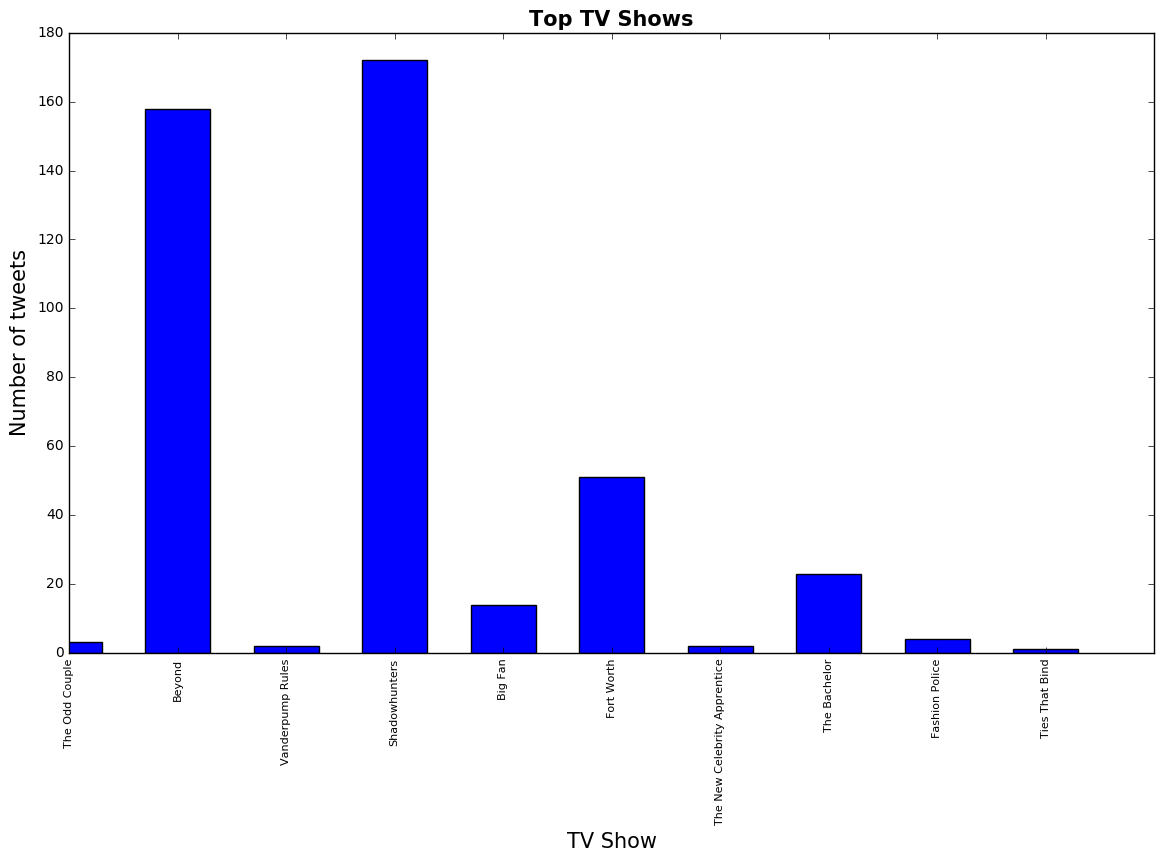

In [126]:
graph_tweets(tweet_file, show_names)

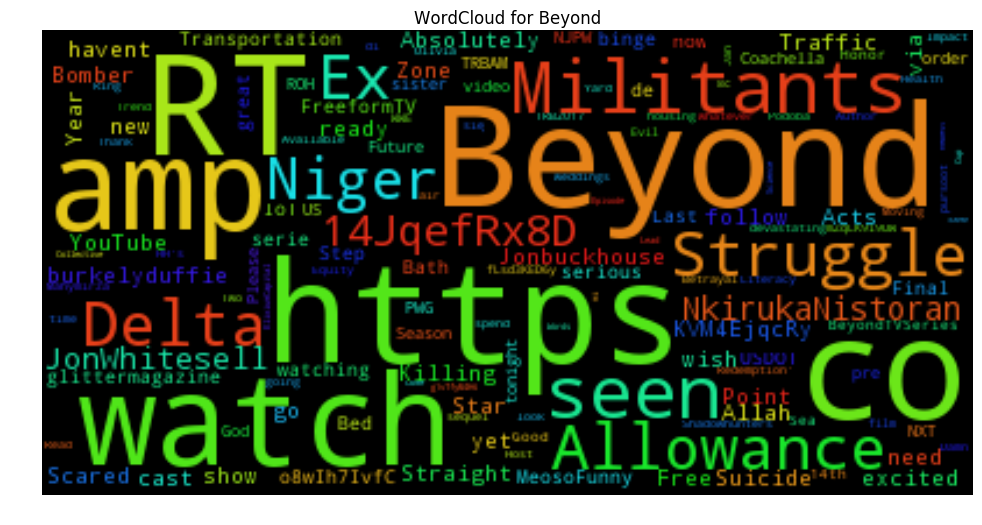

In [127]:
plot_word_cloud(tweet_file, ['Beyond'])

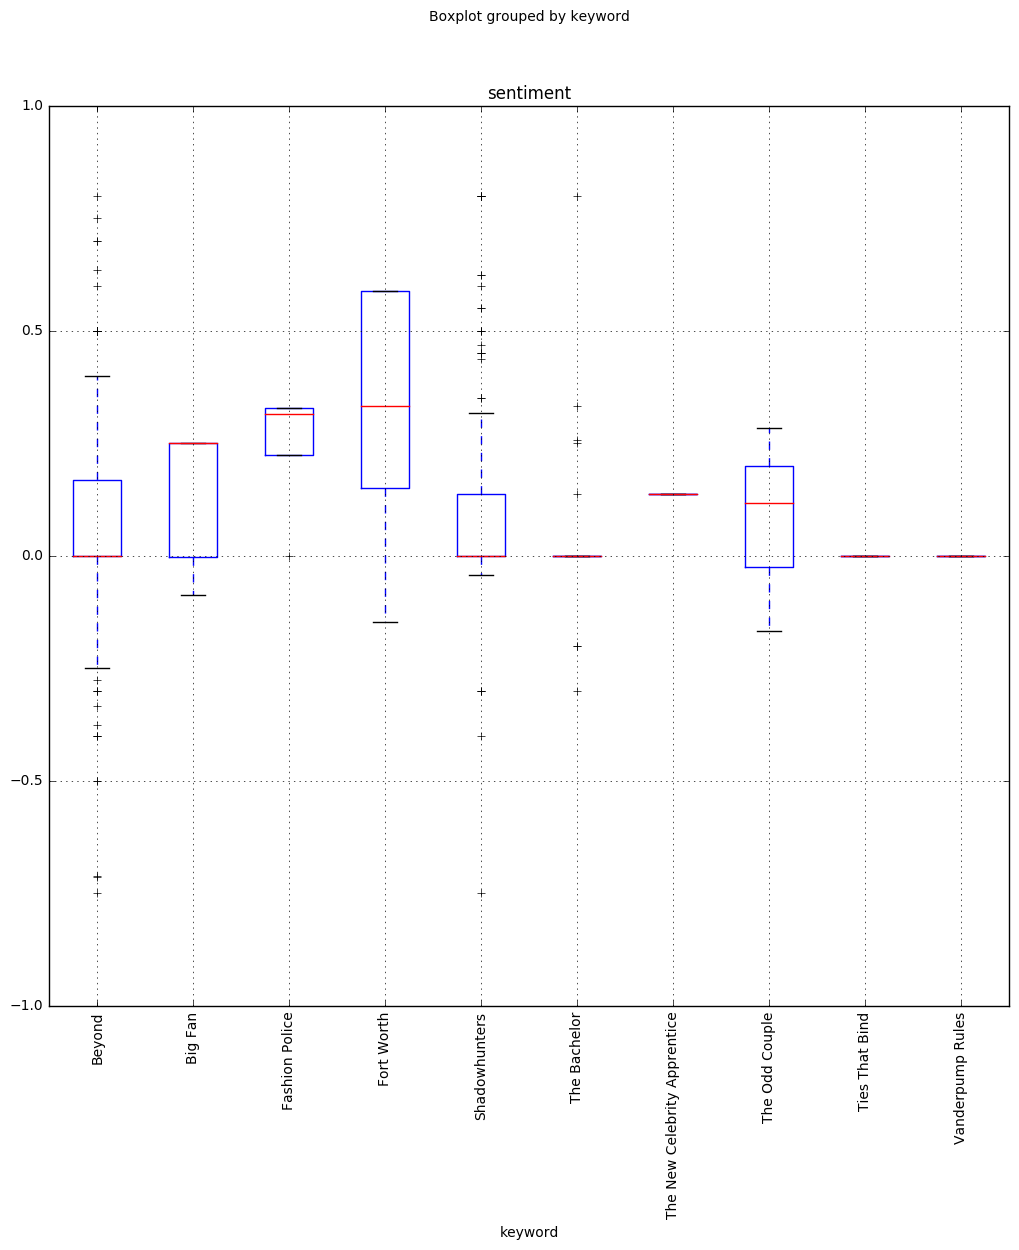

In [132]:
graph_sentiments(tweet_file, show_names)